<a href="https://colab.research.google.com/github/KurtGabrielAnduque/CPE-313/blob/main/Transfer_Learning_on_PyTorch_ANDUQUE_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning using PyTorch

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [48]:
!nvidia-smi

Thu Feb 19 07:29:37 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   73C    P0             33W /   70W |    3901MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Load Important Libraries

In [49]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

## Load Data
=========

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we\'re going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants
and bees. There are 75 validation images for each class. Usually, this
is a very small dataset to generalize upon, if trained from scratch.
Since we are using transfer learning, we should be able to generalize
reasonably well.

This dataset is a very small subset of imagenet.


In [50]:
!rm -R /content/hymenoptera_data/train/.ipynb_checkpoints
!ls /content/drive/MyDrive/hymenoptera_data/train -a   #to make sure that the deletion has occurred

!rm -R /content/hymenoptera_data/val/.ipynb_checkpoints
!ls /content/drive/MyDrive/hymenoptera_data/val -a   #to make sure that the deletion has occurred

rm: cannot remove '/content/hymenoptera_data/train/.ipynb_checkpoints': No such file or directory
ants  bees
rm: cannot remove '/content/hymenoptera_data/val/.ipynb_checkpoints': No such file or directory
ants  bees


In [51]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# We want to be able to train our model on an `accelerator <https://pytorch.org/docs/stable/torch.html#accelerators>`__
# such as CUDA, MPS, MTIA, or XPU. If the current accelerator is available, we will use it. Otherwise, we use the CPU.

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## Visualize a few images
======================

Let\'s visualize a few training images so as to understand the data
augmentations.


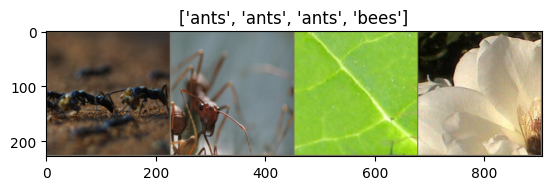

In [52]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Training the model
==================

Now, let\'s write a general function to train a model. Here, we will
illustrate:

-   Scheduling the learning rate
-   Saving the best model

In the following, parameter `scheduler` is an LR scheduler object from
`torch.optim.lr_scheduler`.


In [53]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

## Visualizing the model predictions
=================================

Generic function to display predictions for a few images


In [54]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Finetuning the ConvNet
======================

Load a pretrained model and reset final fully connected layer.


In [11]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 210MB/s]


## Train and evaluate
==================

It should take around 15-25 min on CPU. On GPU though, it takes less
than a minute.


In [12]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5932 Acc: 0.7090
val Loss: 0.2460 Acc: 0.9020

Epoch 1/24
----------
train Loss: 0.5696 Acc: 0.7705
val Loss: 0.2922 Acc: 0.8824

Epoch 2/24
----------
train Loss: 0.4216 Acc: 0.8238
val Loss: 0.2688 Acc: 0.9216

Epoch 3/24
----------
train Loss: 0.3768 Acc: 0.8811
val Loss: 0.4262 Acc: 0.8431

Epoch 4/24
----------
train Loss: 0.5566 Acc: 0.7869
val Loss: 0.3113 Acc: 0.8693

Epoch 5/24
----------
train Loss: 0.4740 Acc: 0.7869
val Loss: 0.2446 Acc: 0.9281

Epoch 6/24
----------
train Loss: 0.7427 Acc: 0.7664
val Loss: 0.7790 Acc: 0.7712

Epoch 7/24
----------
train Loss: 0.5608 Acc: 0.8156
val Loss: 0.2841 Acc: 0.9150

Epoch 8/24
----------
train Loss: 0.3177 Acc: 0.8893
val Loss: 0.3047 Acc: 0.8954

Epoch 9/24
----------
train Loss: 0.3358 Acc: 0.8893
val Loss: 0.2232 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.3601 Acc: 0.8648
val Loss: 0.2445 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.2454 Acc: 0.9016
val Loss: 0.2521 Acc: 0.9216

Ep

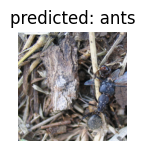

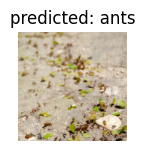

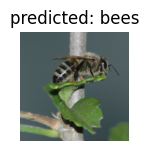

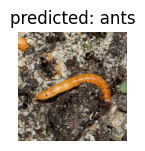

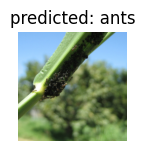

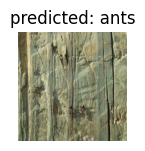

In [13]:
visualize_model(model_ft)

## ConvNet as fixed feature extractor
==================================

Here, we need to freeze all the network except the final layer. We need
to set `requires_grad = False` to freeze the parameters so that the
gradients are not computed in `backward()`.

You can read more about this in the documentation
[here](https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward).


In [14]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

## Train and evaluate
==================

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don\'t need to be computed for most of the
network. However, forward does need to be computed.


In [15]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.5842 Acc: 0.7090
val Loss: 0.2583 Acc: 0.8954

Epoch 1/24
----------
train Loss: 0.5243 Acc: 0.7541
val Loss: 0.2929 Acc: 0.8954

Epoch 2/24
----------
train Loss: 0.4540 Acc: 0.7951
val Loss: 0.2168 Acc: 0.9281

Epoch 3/24
----------
train Loss: 0.4340 Acc: 0.7787
val Loss: 0.6158 Acc: 0.7582

Epoch 4/24
----------
train Loss: 0.4574 Acc: 0.7787
val Loss: 0.1805 Acc: 0.9477

Epoch 5/24
----------
train Loss: 0.5019 Acc: 0.8033
val Loss: 0.4194 Acc: 0.8497

Epoch 6/24
----------
train Loss: 0.4236 Acc: 0.7992
val Loss: 0.2587 Acc: 0.9216

Epoch 7/24
----------
train Loss: 0.2813 Acc: 0.8852
val Loss: 0.2086 Acc: 0.9281

Epoch 8/24
----------
train Loss: 0.2694 Acc: 0.8975
val Loss: 0.2408 Acc: 0.9150

Epoch 9/24
----------
train Loss: 0.2956 Acc: 0.8770
val Loss: 0.2117 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.3377 Acc: 0.8566
val Loss: 0.2018 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.3445 Acc: 0.8443
val Loss: 0.2140 Acc: 0.9281

Epoch 12/24
----------
t

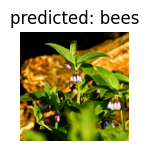

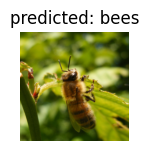

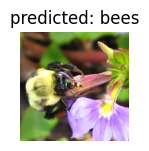

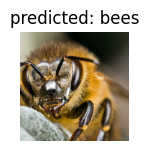

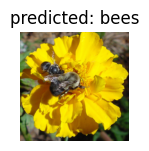

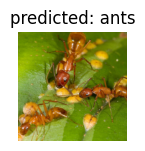

In [16]:
visualize_model(model_conv)

plt.ioff()
plt.show()

## Inference on custom images
==========================

Use the trained model to make predictions on custom images and visualize
the predicted class labels along with the images.


In [55]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

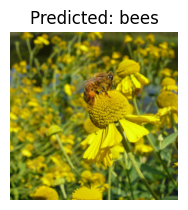

In [18]:
visualize_model_predictions(
    model_conv,
    img_path='/content/drive/MyDrive/hymenoptera_data/val/bees/1355974687_1341c1face.jpg'
)

plt.ioff()
plt.show()

## Further Learning
================

If you would like to learn more about the applications of transfer
learning, checkout the
* [Quantized Transfer Learning for Computer Vision
Tutorial](https://pytorch.org/tutorials/intermediate/quantized_transfer_learning_tutorial.html).


# Supplementary Activity

In a new notebook, perform the following:
1. Choose a pretrained model.
2. Finetune on your dataset from the previous activity.
3. Evaluate the performance of the previous model to this finetuned model.

4. Utilize the pretrained ConvNet model as fixed feature extractor.
5. Evaluate the performance of the previous model to this finetuned model.

6.  Discuss the following:
  * How did finetuning affect your performance?
  * Which of the different situations for rule of thumb were applicable to you?

<b> Import the necessary libraries

<b>1. Choose a pretrained model.

In [26]:
import torch.optim as optim
from torch.optim import lr_scheduler

In [59]:
model_ENet = models.efficientnet_b7(weights='IMAGENET1K_V1')
num_ftrs = model_ENet.features

model_ENet = model_ENet.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-c5b4e57e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-c5b4e57e.pth


100%|██████████| 255M/255M [00:01<00:00, 166MB/s]


<b>2. Finetune on your dataset from the previous activity.

In [60]:
criterion = nn.CrossEntropyLoss()

optimizer_ENet = optim.Adam(model_ENet.parameters(), lr = 0.001)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ENet,step_size=7, gamma=0.1)

<b>3. Evaluate the performance of the previous model to this finetuned model.

In [61]:
model_R50 = train_model(model_ENet, criterion, optimizer_ENet, exp_lr_scheduler,num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 1.8355 Acc: 0.6066
val Loss: 0.5298 Acc: 0.7451

Epoch 1/24
----------
train Loss: 0.5737 Acc: 0.7377
val Loss: 0.3370 Acc: 0.8693

Epoch 2/24
----------
train Loss: 0.5427 Acc: 0.7623
val Loss: 0.5020 Acc: 0.8039

Epoch 3/24
----------
train Loss: 0.4465 Acc: 0.8156
val Loss: 0.5721 Acc: 0.8170

Epoch 4/24
----------
train Loss: 0.5487 Acc: 0.7377
val Loss: 0.3953 Acc: 0.8431

Epoch 5/24
----------
train Loss: 0.4661 Acc: 0.7910
val Loss: 0.5559 Acc: 0.7712

Epoch 6/24
----------
train Loss: 0.4357 Acc: 0.8156
val Loss: 0.3559 Acc: 0.8562

Epoch 7/24
----------
train Loss: 0.4156 Acc: 0.8197
val Loss: 0.3154 Acc: 0.8889

Epoch 8/24
----------
train Loss: 0.3190 Acc: 0.8852
val Loss: 0.2959 Acc: 0.9085

Epoch 9/24
----------
train Loss: 0.3264 Acc: 0.8811
val Loss: 0.2983 Acc: 0.9020

Epoch 10/24
----------
train Loss: 0.2649 Acc: 0.8648
val Loss: 0.2905 Acc: 0.8954

Epoch 11/24
----------
train Loss: 0.3613 Acc: 0.8320
val Loss: 0.2707 Acc: 0.9150

Epoch 12/24
----------
t

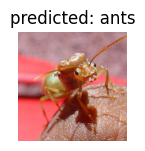

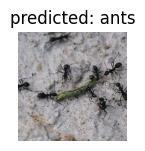

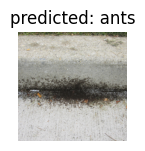

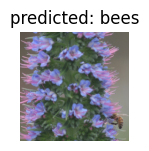

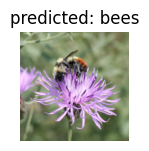

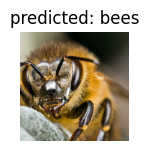

In [67]:
visualize_model(model_R50)

<b> 4. Utilize the pretrained ConvNet model as fixed feature extractor.

In [65]:
model_conv_ENet = torchvision.models.efficientnet_b7(weights='IMAGENET1K_V1')
for param in model_conv_ENet.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default


model_conv_ENet = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv_Enet = optim.SGD(model_conv_ENet.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv_Enet, step_size=7, gamma=0.1)

<b> 5. Evaluate the performance of the previous model to this finetuned model.


In [66]:
model_conv_ENet = train_model(model_conv_ENet, criterion, optimizer_conv_Enet, exp_lr_scheduler,num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.4231 Acc: 0.8279
val Loss: 0.1852 Acc: 0.9542

Epoch 1/24
----------
train Loss: 0.5480 Acc: 0.7582
val Loss: 0.2398 Acc: 0.9216

Epoch 2/24
----------
train Loss: 0.4945 Acc: 0.7869
val Loss: 0.2014 Acc: 0.9346

Epoch 3/24
----------
train Loss: 0.3900 Acc: 0.8566
val Loss: 0.2333 Acc: 0.9281

Epoch 4/24
----------
train Loss: 0.3761 Acc: 0.8361
val Loss: 0.2110 Acc: 0.9412

Epoch 5/24
----------
train Loss: 0.4859 Acc: 0.8238
val Loss: 0.2466 Acc: 0.9216

Epoch 6/24
----------
train Loss: 0.4041 Acc: 0.8320
val Loss: 0.2720 Acc: 0.9216

Epoch 7/24
----------
train Loss: 0.4173 Acc: 0.8320
val Loss: 0.2049 Acc: 0.9281

Epoch 8/24
----------
train Loss: 0.2975 Acc: 0.8811
val Loss: 0.2346 Acc: 0.9216

Epoch 9/24
----------
train Loss: 0.4237 Acc: 0.8033
val Loss: 0.2164 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.3481 Acc: 0.8361
val Loss: 0.2190 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.3388 Acc: 0.8525
val Loss: 0.2059 Acc: 0.9281

Epoch 12/24
----------
t

<b> The model was capable of reaching 95% accuracy score which is higher compared to the recent model.

In [76]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

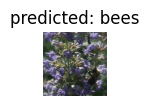

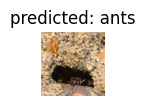

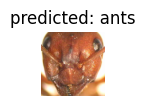

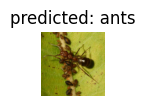

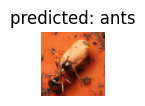

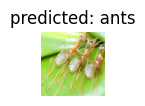

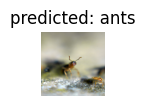

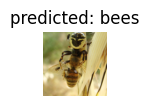

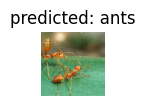

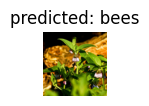

In [77]:
visualize_model(model_conv_ENet)

<b> Base on the result of the classification in the images this new model was able to classify the first 10 accurately.

In [78]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

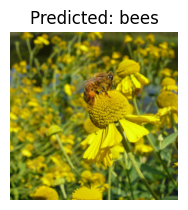

In [79]:
#How about the val data
visualize_model_predictions(
    model_conv_ENet,
    img_path='/content/drive/MyDrive/hymenoptera_data/val/bees/1355974687_1341c1face.jpg'
)

plt.ioff()
plt.show()

Yeah it is capable of predicting even the unseen datasets.

<b>6.  Discuss the following:
- How did finetuning affect your performance?

Answer: </b>
- Performing a finetuning in a pretrained model, help our model to perform better since we are able to monitor its learning rate and adjust it according to the result because of the lr scheduler. Furthermore, we are free to change the optmizer we can use depending on the given dataset.

<b>
- Which of the different situations for rule of thumb were applicable to you?

Answer:</b>
- When creating a model, I always consider creating a simple layer. Where the filters are starting from few, same with the kernel size, and the maxpooling parameters. As the layers starts to increase it the parameters must also increase directly proportional to it inorder for the layers to decompose the pattern carefully as the layer increase.
